# Building a Plan-and-Execute Agent in LangGraph

In this tutorial, we will build a plan-and-execute agent using LangGraph. This agent will:

- Plan a series of steps to answer complex, multi-step queries.
- Execute each step using tools and an LLM.
- Re-plan if necessary, updating the plan based on intermediate results.

By the end of this tutorial, you'll have a robust agent capable of handling intricate queries by planning and executing tasks systematically.

### Overview
Our agent will:

1. Receive a complex query from the user.
2. Plan a sequence of steps to answer the query.
3. Execute each step, possibly using tools (like web search).
4. Re-plan if needed, adjusting the plan based on new information.
5. Provide the final answer to the user.


### Imports
We start by importing the necessary libraries:


In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import START, END
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

_ = load_dotenv()

### Defining the Model
We use the gpt-4o model from OpenAI:

In [2]:
# Defining the model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Defining the Tools
We will define a web search tool using Tavily:

In [3]:
# Tavily Search Tool
tavily_search = TavilySearchResults(max_results=3)

# List of tools for the agent
tools = [tavily_search]

### Defining the State
Our agent needs to maintain state across planning and execution steps. We define the State as follows:

In [4]:
class State(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple[str, str]], operator.add]  # List of (step, result)
    response: str

### Planning Step
We create a planning function that generates a plan based on the user's query:

In [5]:
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(description="A list of steps to achieve the objective.")

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a planning assistant that creates a simple, step-by-step plan to answer the user's query."),
        ("user", "{input}")
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)

### Re-Plan Step
If necessary, the agent can re-plan based on previous results:


In [6]:
class Response(BaseModel):
    """Response to the user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(description="The action to perform next.")

replanner_prompt = ChatPromptTemplate.from_template(
    """
    You are a planning assistant that updates the plan based on completed steps and their results.

    Objective: {input}
    Original Plan: {plan}
    Completed Steps: {past_steps}

    Update the plan accordingly. If all steps are complete and you can provide the final answer, respond with the answer.
    """
)

replanner = replanner_prompt | llm.with_structured_output(Act)

### Defining the Execution Agent
We shall simply use the `create_react_agent` function to create an execution agent that can perform each step using the defined tools.

In [7]:
from langgraph.prebuilt import create_react_agent

execution_agent = create_react_agent(llm, tools)

### Creating the Graph
We define the nodes and edges of our LangGraph:

In [8]:
graph_builder = StateGraph(State)

# Planning node
def planning_node(state: State):
    print("Executing planning node...")
    plan = planner.invoke({"input": state["input"]})
    print(f"Plan created: {plan.steps}")
    return {"plan": plan.steps}

graph_builder.add_node("planner", planning_node)

# Execution node
def execution_node(state: State):
    print("Executing execution node...")
    current_step = state["plan"][0]
    print(f"Current step: {current_step}")
    agent_input = f"Step: {current_step}\n\nPlease execute this step."
    agent_response = execution_agent.invoke({"messages": [("user", agent_input)]})
    result = agent_response["messages"][-1].content
    print(f"Step result: {result}")
    return {
        "past_steps": [(current_step, result)],
        "plan": state["plan"][1:]  # Remove the executed step from the plan
    }

graph_builder.add_node("executor", execution_node)

# Re-planning node
def replanning_node(state: State):
    print("Executing replanning node...")
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        print(f"Replanning complete. Final response: {output.action.response}")
        return {"response": output.action.response}
    else:
        print(f"Replanning complete. Updated plan: {output.action.steps}")
        return {"plan": output.action.steps}

graph_builder.add_node("replanner", replanning_node)

# Conditional edge to decide whether to continue or end
def should_continue(state: State):
    print("Evaluating whether to continue...")
    if state.get("response"):
        print("Final response received. Ending execution.")
        return END
    elif state["plan"]:
        print("Plan steps remaining. Continuing to executor.")
        return "executor"
    else:
        print("No plan steps remaining. Moving to replanner.")
        return "replanner"

graph_builder.add_conditional_edges(
    "replanner",
    should_continue,
    {"executor": "executor", END: END}
)

# Defining edges
graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "executor")
graph_builder.add_edge("executor", "replanner")
graph_builder.set_entry_point("planner")

### Compiling the Graph
We compile the graph to create a runnable agent:

In [9]:
# Setting up checkpointing for state management
memory = MemorySaver()

# Compiling the graph
graph = graph_builder.compile(checkpointer=memory)

### Visualizing the Agent's Workflow
We can visualize the agent's workflow:

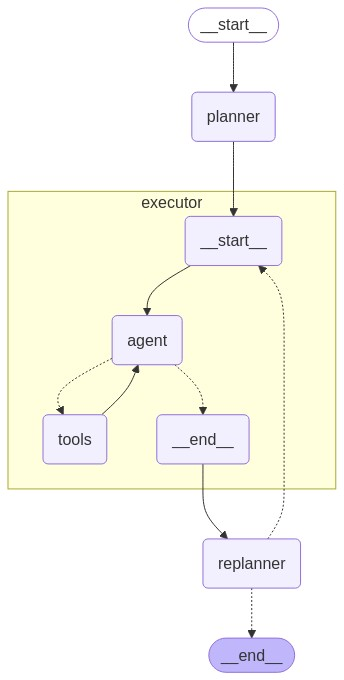

In [10]:
from IPython.display import display, Image

# Visualize the agent's workflow
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Agent
Now, we can interact with our agent.


In [11]:
from IPython.display import display, Markdown

user_query = "Which country will host the next FIFA World Cup, and what are the top three tourist attractions in its capital city?"
inputs = {"input": user_query}
config = {"recursion_limit": 50, "configurable": {"thread_id": "1"}}
events = graph.stream(inputs, config)
for event in events:
    for k, v in event.items():
        if k != "__end__":
            if isinstance(v, dict) and 'response' in v:
                display(Markdown(v['response']))

Executing planning node...


python(66481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Plan created: ['Identify the country hosting the next FIFA World Cup.', 'Research the capital city of that country.', 'List the top three tourist attractions in the capital city.']
Executing execution node...
Current step: Identify the country hosting the next FIFA World Cup.
Step result: The next FIFA World Cup in 2026 will be jointly hosted by three countries: the United States, Canada, and Mexico.
Executing replanning node...
Replanning complete. Updated plan: ['Research the capital city of the United States.', 'List the top three tourist attractions in Washington, D.C.']
Evaluating whether to continue...
Plan steps remaining. Continuing to executor.
Executing execution node...
Current step: Research the capital city of the United States.
Step result: The capital city of the United States is Washington, D.C. Here are some key details:

- **Location**: Washington, D.C. is situated on the Potomac River, bordered by Virginia to the south and west, and Maryland to the north and east.
- 

The next FIFA World Cup in 2026 will be jointly hosted by the United States, Canada, and Mexico. The capital city of the United States is Washington, D.C. The top three tourist attractions in Washington, D.C. are:

1. **Smithsonian National Museum of Natural History** - A renowned museum that showcases a vast range of exhibits related to natural history, including fossils, gems, and cultural artifacts.
2. **Lincoln Memorial** - An iconic monument dedicated to Abraham Lincoln, featuring a large seated sculpture of the president and inscriptions of two of his most famous speeches.
3. **National Air and Space Museum** - This museum houses the largest collection of historic aircraft and spacecraft in the world, making it a must-visit for aviation and space enthusiasts.

### Conclusion
Congratulations! You've built a plan-and-execute agent using LangGraph that can handle complex, multi-step queries by planning and executing tasks systematically.

Feel free to experiment further by:

- Adding more tools.
- Modifying the planning and replanning prompts.
- Handling different types of multi-step queries.
